In [3]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from tqdm.notebook import trange
from tqdm.notebook import trange
%matplotlib widget

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [4]:
train_set = CIFAR10(
    download=True,
    root='./dataset',
    train=True,
    transform=ToTensor()
)
test_set = CIFAR10(
    download=True,
    root='./dataset',
    train=False,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


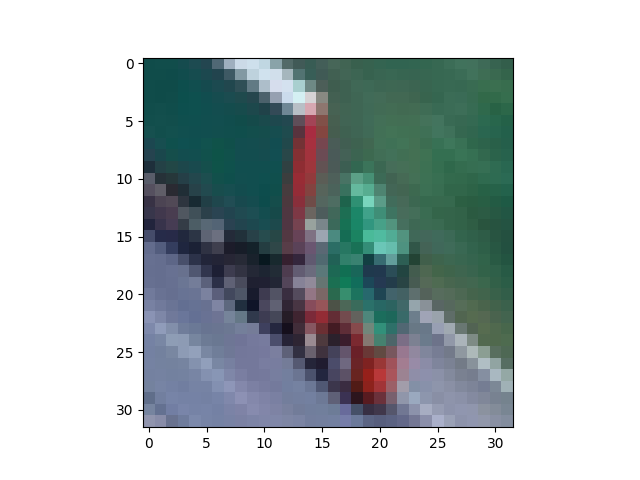

In [24]:
fig, ax = plt.subplots()

def imshow(img, ax=None):
    npimg = img.numpy()
    if ax:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(train_set[50][0], ax)

In [6]:
def get_noise(BS=1):
    return torch.randn(BS, 100, requires_grad=True).to(device)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 6, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
        self.input_layer = nn.Sequential(
            nn.Linear(100, 4*4*512),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.reshape(-1, 512, 4, 4)
        return self.conv(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 6, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, 5),
            nn.LeakyReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*512, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv(x)
        return self.output_layer(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


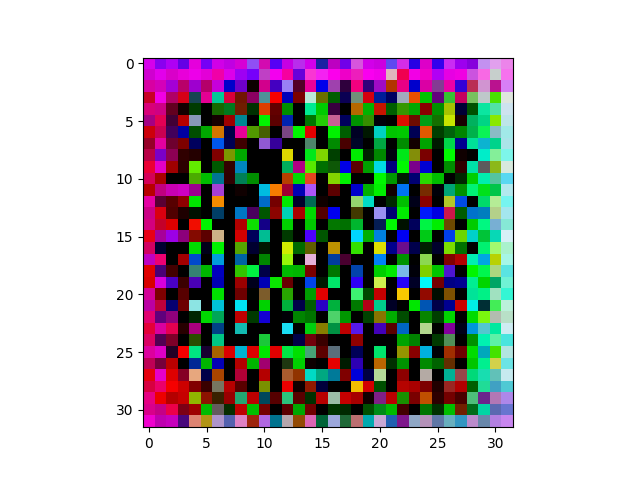

In [63]:
G = Generator().to(device)
D = Discriminator().to(device)

x = G(get_noise())

fig, ax = plt.subplots()
imshow(x[0].detach().cpu(), ax)

In [65]:
BS = 32

train_dtld = DataLoader(train_set, batch_size=BS)

optim_d = torch.optim.Adam(D.parameters(), lr=1e-7)
optim_g = torch.optim.Adam(G.parameters(), lr=1e-7)

loss_fn = nn.BCELoss()
epochs = 2

d_losses = []
d_accs = []
g_losses = []

fig.set_size_inches([6, 9])

for epoch in (t:=trange(epochs)):
    for ax in axs:
        ax.clear()

    for batch, (X, _) in enumerate(train_dtld):
        X = X.to(device)
        z = get_noise(BS=BS)
        
        # Updating discrimator
        real_pred = D(X)
        fake_pred = D(G(z).detach())
        
        real_loss = loss_fn(
            real_pred, torch.full_like(real_pred, .9)
        )
        fake_loss = loss_fn(
            fake_pred, torch.full_like(fake_pred, 0)
        )
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()
        
        d_losses.append(d_loss.item())\
        
        true_reals = torch.count_nonzero(torch.round(real_pred))
        true_fakes = len(fake_pred) - torch.count_nonzero(torch.round(fake_pred))
        acc = (true_reals + true_fakes) / \
            (len(real_pred) + len(fake_pred))
        
        d_accs.append(acc.cpu())
        
        for p in D.parameters():
            p.grad = None
        
        # Updating generator
        fake_pred = D(G(z))
        g_loss = loss_fn(fake_pred, torch.full_like(fake_pred, 1))
        
        g_loss.backward()
        optim_g.step()
        g_losses.append(g_loss.item())
        
        for p in G.parameters():
            p.grad = None
 
    axs[0].plot(d_losses, label='Discriminator')
    axs[0].plot(g_losses, label='Generator')
    axs[0].set_title('Losses')
    axs[0].legend()
    
    axs[1].set_title('Acc')
    axs[1].plot(d_accs)
    
    imshow(G(z).detach().cpu()[0], axs[2])
    fig.canvas.draw()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


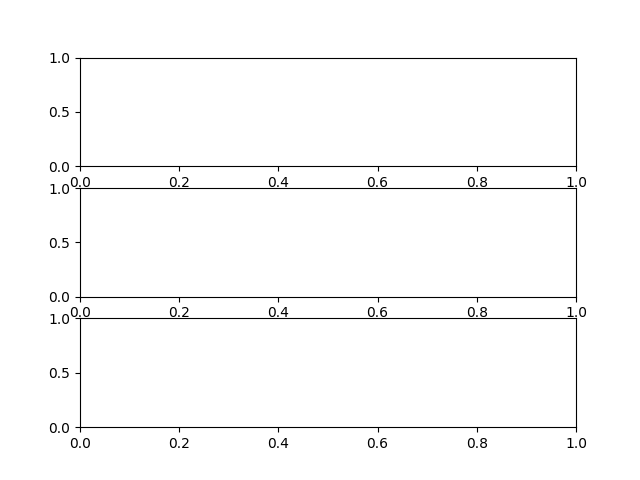

In [30]:
fig, axs = plt.subplots(3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


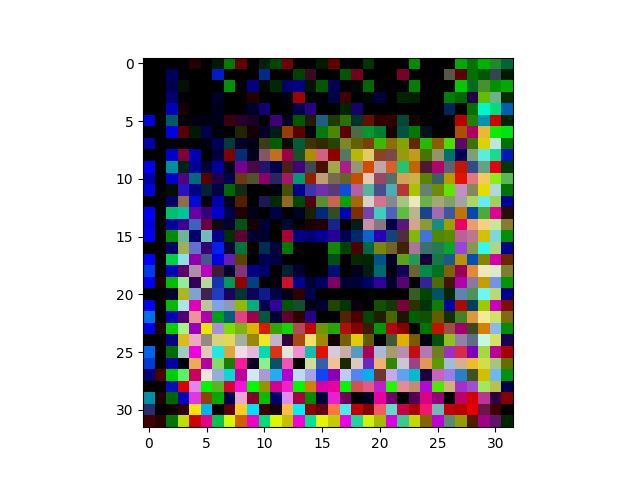

In [71]:
x = G(get_noise())

fig, ax = plt.subplots()
imshow(x[0].detach().cpu(), ax)